# Интернет-магазин «В один клик»

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. 

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Предоставдены данные в табличной форме. 

+ `market_file.csv` - содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

    + `id` — номер покупателя в корпоративной базе данных.
    + `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    + `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
    + `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    + `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    + `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
    + `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    + `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    + `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
    + `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    + `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
    + `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

+ `market_money.csv` - с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

    + `id` — номер покупателя в корпоративной базе данных.
    + `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    + `Выручка` — сумма выручки за период.

+ `market_time.csv` - с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

    + `id` — номер покупателя в корпоративной базе данных.
    + `Период` — название периода, во время которого зафиксировано общее время.
    + `минут` — значение времени, проведённого на сайте, в минутах.

+ `money.csv` - с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

    + `id` — номер покупателя в корпоративной базе данных.
    + `Прибыль` — значение прибыли.


Разобъем задачу на два этапа:

1. Разработаем модель, которая предскажет вероятность снижения покупательской активности.
2. Выделим сегмент покупателей, проанализируем его и предложим, как увеличить его покупательскую активность, используя данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). Возможные сегменты:
+ Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
+ Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
+ Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
+ Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

План работы:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

## Загрузка данных

 **Установка пакетов**

In [2]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas  as pd
import phik
import seaborn as sns
import shap

from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42

### Загрузка датасетов

Исходя из технического задания у нас есть 4 датасета:
+ `market_file.csv` - содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
+ `market_money.csv` - с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
+ `market_time.csv` - с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
+ `money.csv` - с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')

In [6]:
market_money = pd.read_csv('/datasets/market_money.csv')

In [5]:
market_time = pd.read_csv('/datasets/market_time.csv')

In [7]:
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

## Предобработка данных

### Предобработка market_file

In [9]:
market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Немного изменим названия столбцов

In [10]:
market_file.columns = map(str.lower, market_file.columns)
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [14]:
market_file["покупательская_активность"].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [15]:
market_file["разрешить_сообщать"].unique()

array(['да', 'нет'], dtype=object)

In [16]:
market_file["популярная_категория"].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [17]:
market_file["тип_сервиса"].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Посмотрев информацию о данных столбцов, можно увидить явные грамматические ошибки и еще некоторые опечатки. Исправим это

In [18]:
market_file["тип_сервиса"] = market_file["тип_сервиса"].replace(['стандартт'],'стандарт')
market_file["популярная_категория"] = market_file["популярная_категория"].replace(['Косметика и аксесуары'],'Косметика и аксессуары')
market_file["популярная_категория"].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [19]:
market_file["тип_сервиса"].unique()

array(['премиум', 'стандарт'], dtype=object)

Данные исправлены, проверим их на дубликаты

In [20]:
print('Явных дубликатов:', market_file.duplicated().sum(), '\n')
market_file.info()

Явных дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_с

### Предобработка market_money

In [21]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [22]:
market_money["Период"].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Также как и с предыдущим датасетом немного поправим названия столбцов. Затем выведем информацию о датасете `market_money`

In [23]:
market_money.columns = map(str.lower, market_money.columns)
print('Явных дубликатов:', market_money.duplicated().sum(), '\n')
market_money.info()

Явных дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### Предобработка market_time

Проводим все те же операции

In [24]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [25]:
market_time.columns = map(str.lower, market_time.columns)
market_time["период"].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [26]:
market_time["период"] = market_time["период"].replace(['предыдцщий_месяц'],'предыдущий_месяц')
print('Явных дубликатов:', market_time.duplicated().sum(), '\n')
market_time.info()

Явных дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### Предобработка money

In [27]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [28]:
money.columns = map(str.lower, money.columns)
print('Явных дубликатов:', money.duplicated().sum(), '\n')
money.info()

Явных дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


***Вывод по предобработке данных***

В представленных данных пропуски не обнаружены

Произведено изменение названий столбцов:
+ перевод в строчный формат
+ замена пробелов на подчеркивание

В `market_file` 
+ в колонке `тип_сервиса` данные `стандартт` заменены на `стандарт`
+ в колонке `популярная_категория` данные `Косметика и аксесуары` заменены на `Косметика и аксессуары`

В `market_money`
+ в колонке `период`данные `препредыдущий_месяц` заменены на `предыдущий_месяц`

В `market_time`
+ в колонке `период` данные `предыдцщий_месяц` заменены на `предыдущий_месяц`

##  Исследовательский анализ данных

In [29]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


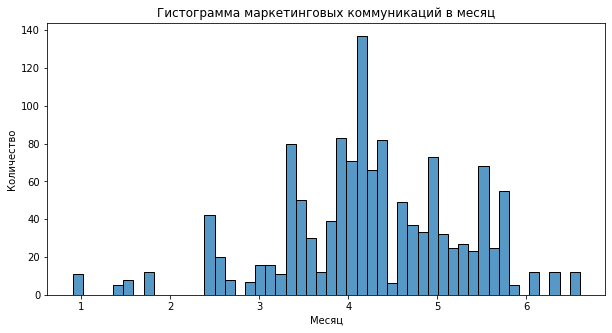

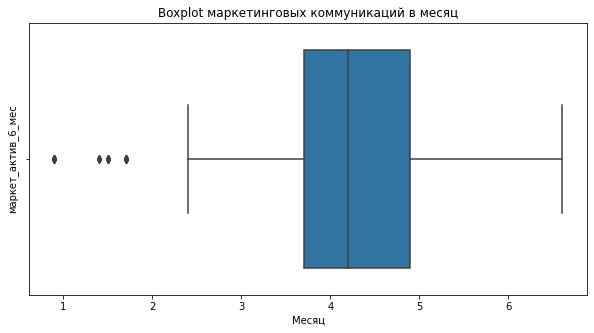

In [30]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_file, x="маркет_актив_6_мес", bins=50)
plt.title('Гистограмма маркетинговых коммуникаций в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_file["маркет_актив_6_мес"])
plt.title('Boxplot маркетинговых коммуникаций в месяц')
plt.xlabel('Месяц')
plt.ylabel('маркет_актив_6_мес')
plt.show()

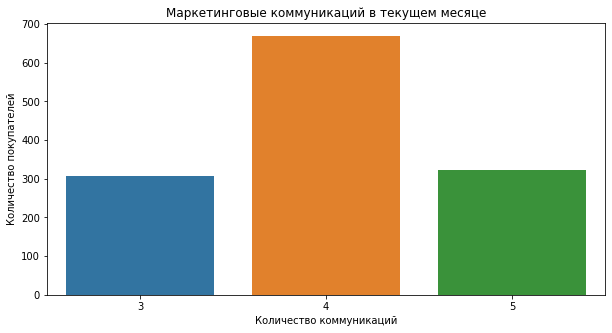

In [31]:
plt.subplots(figsize = (10,5))
sns.countplot(x = 'маркет_актив_тек_мес', data =  market_file)
plt.title('Маркетинговые коммуникаций в текущем месяце')
plt.xlabel('Количество коммуникаций')
plt.ylabel('Количество покупателей')
plt.show();

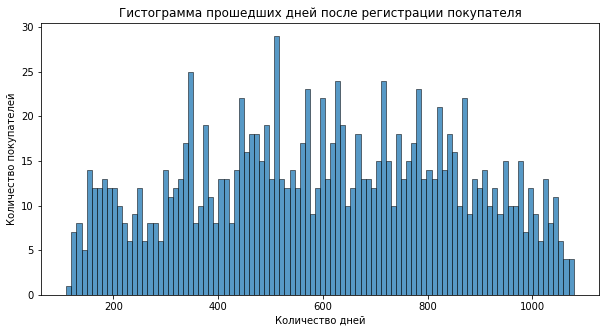

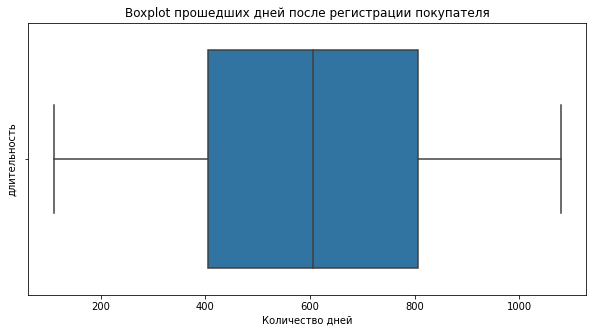

In [32]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_file, x='длительность', bins=100)
plt.title('Гистограмма прошедших дней после регистрации покупателя')
plt.xlabel('Количество дней')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_file['длительность'])
plt.title('Boxplot прошедших дней после регистрации покупателя')
plt.xlabel('Количество дней')
plt.ylabel('длительность')
plt.show()

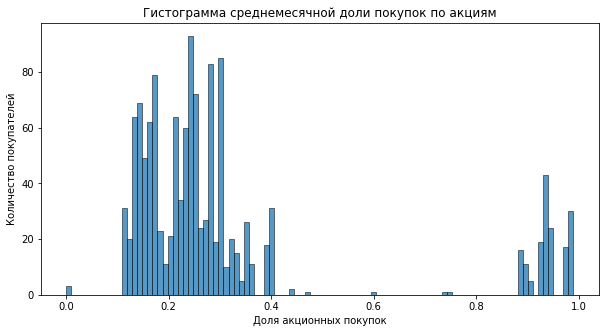

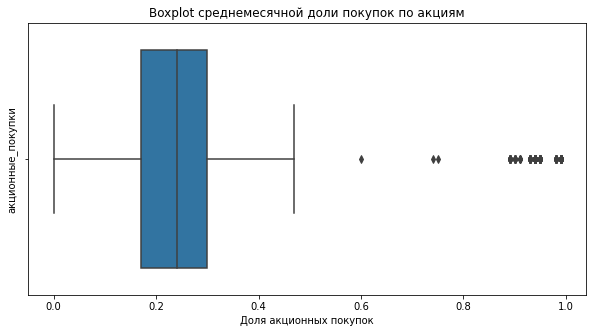

In [33]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_file, x='акционные_покупки', bins=100)
plt.title('Гистограмма среднемесячной доли покупок по акциям')
plt.xlabel('Доля акционных покупок')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_file['акционные_покупки'])
plt.title('Boxplot среднемесячной доли покупок по акциям')
plt.xlabel('Доля акционных покупок')
plt.ylabel('акционные_покупки')
plt.show()

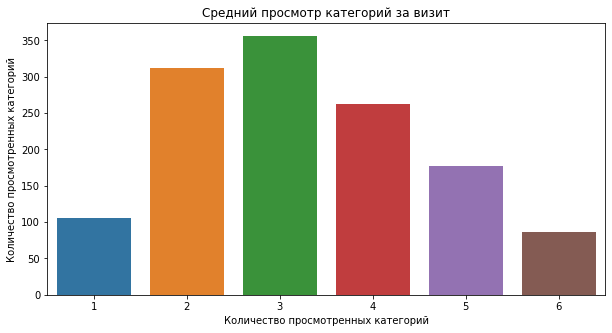

In [34]:
plt.subplots(figsize = (10,5))
sns.countplot(x = 'средний_просмотр_категорий_за_визит', data =  market_file)
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Количество просмотренных категорий')
plt.ylabel('Количество просмотренных категорий')
plt.show()

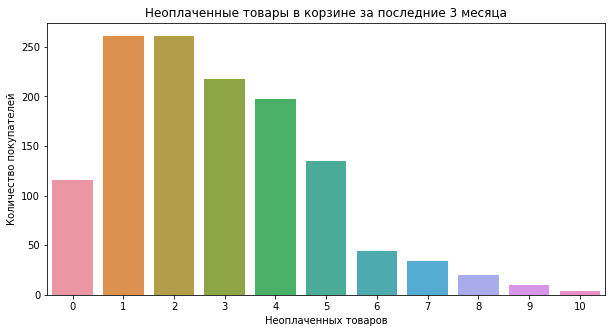

In [35]:
plt.subplots(figsize = (10,5))
sns.countplot(x = 'неоплаченные_продукты_штук_квартал', data =  market_file)
plt.title('Неоплаченные товары в корзине за последние 3 месяца')
plt.xlabel('Неоплаченных товаров')
plt.ylabel('Количество покупателей')
plt.show()

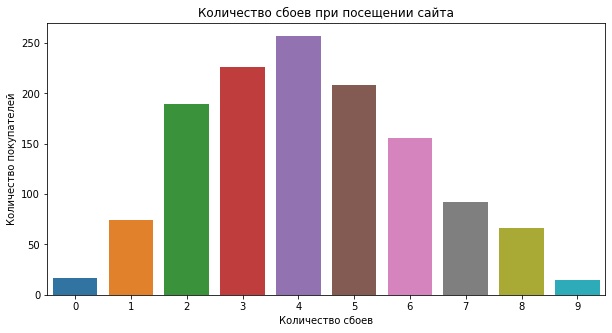

In [36]:
plt.subplots(figsize = (10,5))
sns.countplot(x = 'ошибка_сервиса', data =  market_file)
plt.title('Количество сбоев при посещении сайта')
plt.xlabel('Количество сбоев')
plt.ylabel('Количество покупателей')
plt.show()

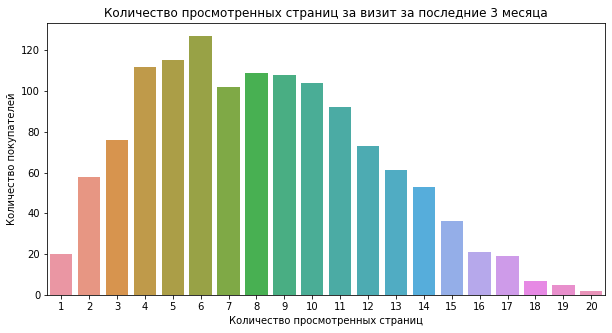

In [37]:
plt.subplots(figsize = (10,5))
sns.countplot(x = 'страниц_за_визит', data =  market_file)
plt.title('Количество просмотренных страниц за визит за последние 3 месяца')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество покупателей')
plt.show()

Анализ строковых значений `market_file`

In [38]:
market_file.describe(include='object')

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


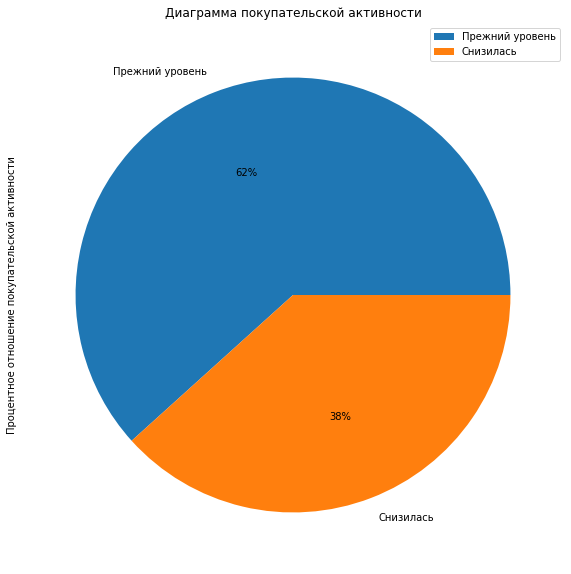

In [39]:
(
market_file
    .pivot_table(index='покупательская_активность',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение покупательской активности')
)
plt.title('Диаграмма покупательской активности')
plt.show()

В данных присутствует дисбаланс целевой переменной  62 на 38. Учтем это при выборе лучшей метрики для нашей модели.

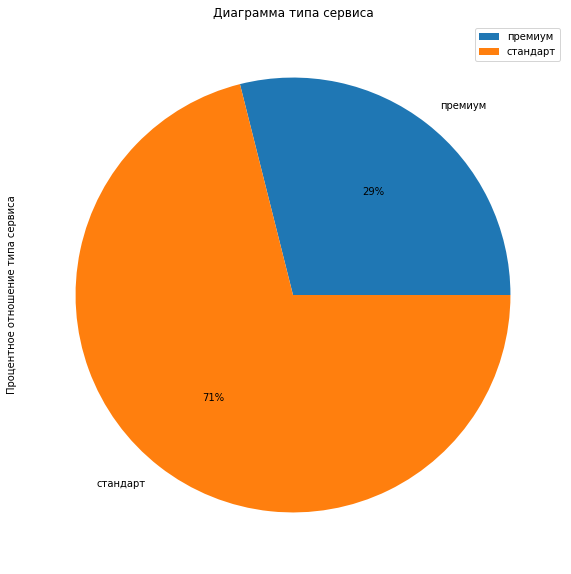

In [40]:
(
market_file
    .pivot_table(index='тип_сервиса',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение типа сервиса')
)
plt.title('Диаграмма типа сервиса')
plt.show()

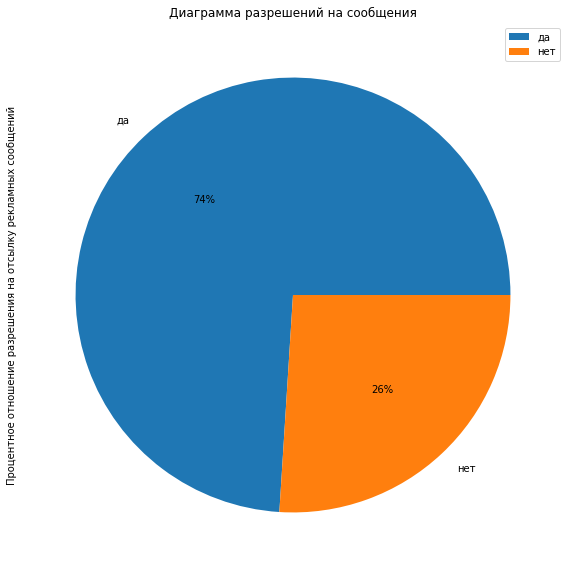

In [41]:
(
market_file
    .pivot_table(index='разрешить_сообщать',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение разрешения на отсылку рекламных сообщений')
)
plt.title('Диаграмма разрешений на сообщения')
plt.show()

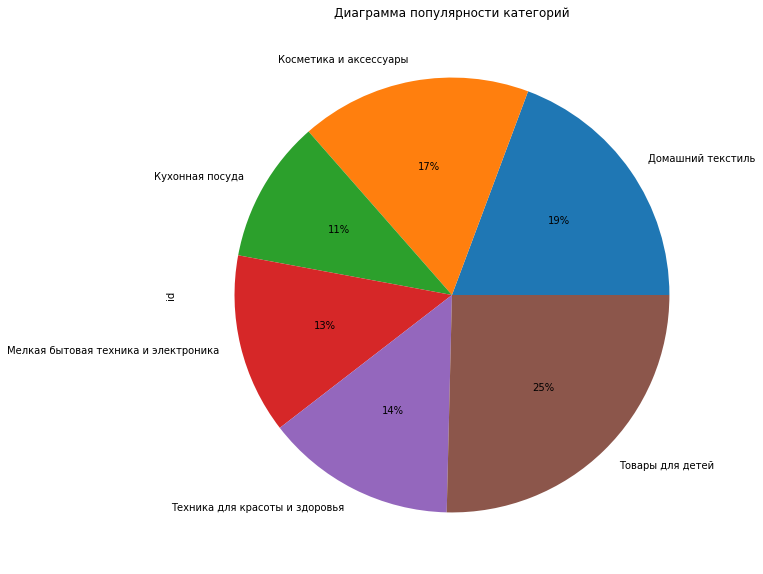

In [42]:
(
market_file
    .pivot_table(index='популярная_категория',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10))              
)
plt.title('Диаграмма популярности категорий')
plt.legend().remove()
plt.show()

**Анализ `market_money`**
<br>
В соответствии с заданием, нужно отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Оставим в таблице только клиентов которые активны все три месяца.

In [43]:
market_money = market_money[market_money.id.isin(market_money.query('выручка==0')['id'].unique())==False] 
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   период   3891 non-null   object 
 2   выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


**Анализ числовых значений `market_money`**

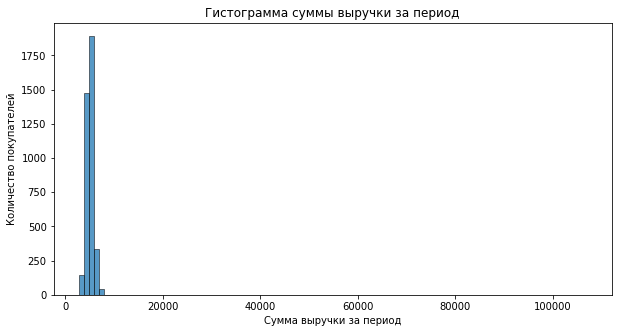

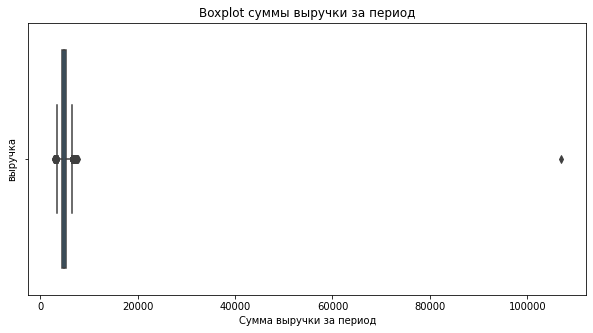

In [45]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_money, x='выручка', bins=100)
plt.title('Гистограмма суммы выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_money['выручка'])
plt.title('Boxplot суммы выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('выручка')
plt.show()

In [46]:
market_money.sort_values(by='выручка', ascending=False).head()

,id,период,выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3
1481,215841,текущий_месяц,7557.0
2388,216144,текущий_месяц,7547.8


Глядя в таблицу, можно увидеть аномально большой выброс. Это мог быть оптовый покупатель, либо ошибка ввода данных.
Необходимо это исправить

In [47]:
market_money['выручка'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: выручка, dtype: float64

In [48]:
display(market_money['выручка'].describe())
market_money = market_money[market_money['выручка'] < 8000]

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: выручка, dtype: float64

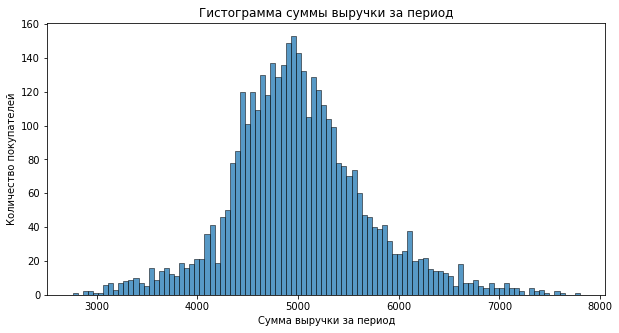

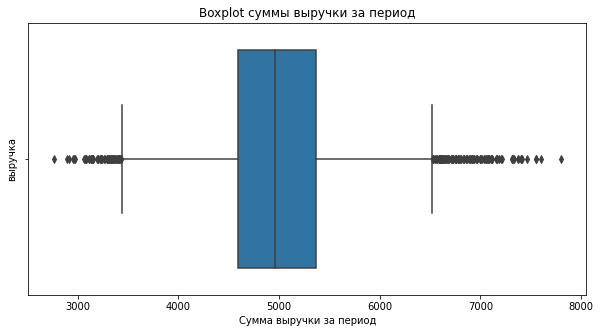

In [49]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_money, x='выручка', bins=100)
plt.title('Гистограмма суммы выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_money['выручка'])
plt.title('Boxplot суммы выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('выручка')
plt.show()

**Анализ строковых значений `market_money`**

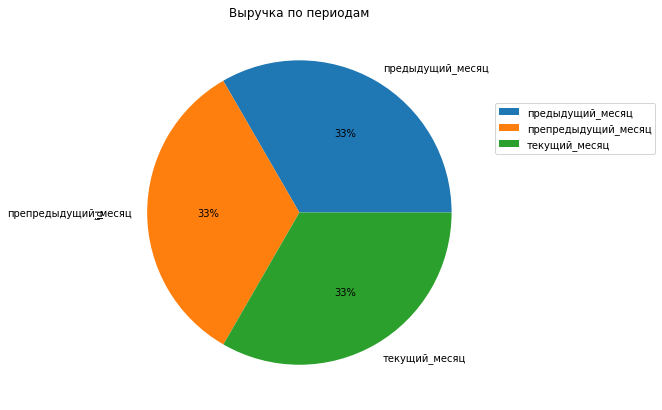

In [50]:
(
market_money
    .pivot_table(index='период', values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), 
              #label='Процентное отношение периодов выручки'
             )
)
plt.title('Выручка по периодам')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.show()

**Анализ числовых значений `market_time`**

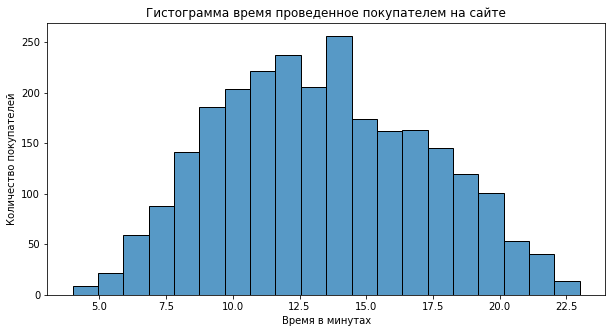

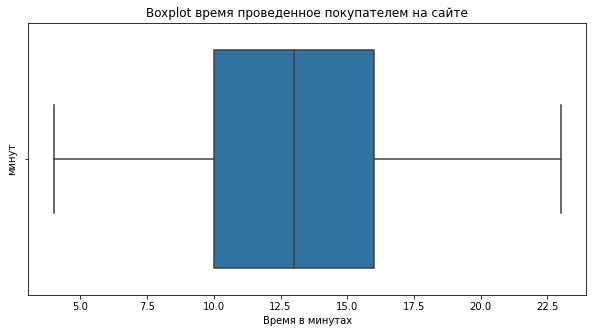

In [51]:
plt.subplots(figsize = (10,5))
sns.histplot(data=market_time, x='минут', bins=20)
plt.title('Гистограмма время проведенное покупателем на сайте')
plt.xlabel('Время в минутах')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_time['минут'])
plt.title('Boxplot время проведенное покупателем на сайте')
plt.xlabel('Время в минутах')
plt.ylabel('минут')
plt.show()

**Анализ строковых значений `market_time`**

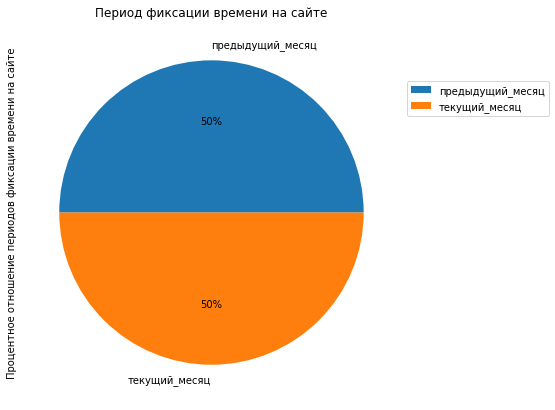

In [52]:
(
market_time
    .pivot_table(index='период', values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), 
              label='Процентное отношение периодов фиксации времени на сайте')
)
plt.title('Период фиксации времени на сайте')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.show()

**Анализ строковых значений `money`**

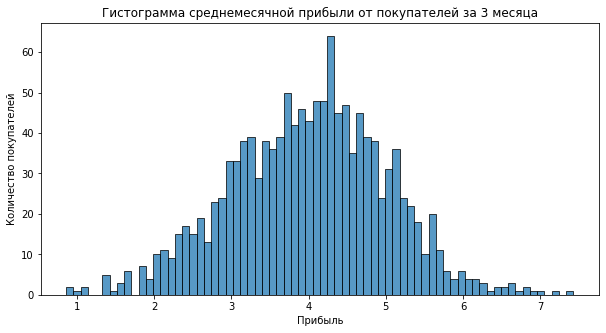

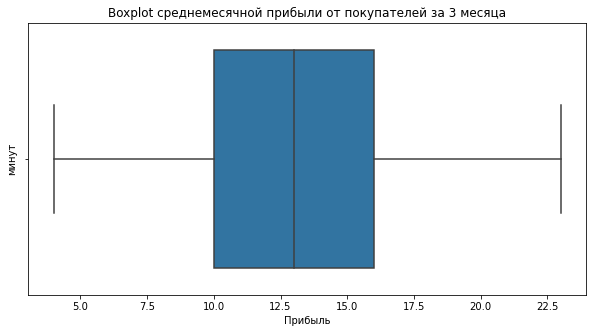

In [53]:
plt.subplots(figsize = (10,5))
sns.histplot(data=money, x='прибыль', bins=70)
plt.title('Гистограмма среднемесячной прибыли от покупателей за 3 месяца')
plt.xlabel('Прибыль')
plt.ylabel('Количество покупателей')
plt.show()

plt.subplots(figsize = (10,5))
sns.boxplot(x=market_time['минут'])
plt.title('Boxplot среднемесячной прибыли от покупателей за 3 месяца')
plt.xlabel('Прибыль')
plt.ylabel('минут')
plt.show()

***Вывод по исследовательскому анализу данных***

В процессе анализа данных выявлены аномальные значения, которые встречаются в значительной части наборов данных. Эти отклонения могут быть обусловлены сезонными колебаниями продаж, специфической активностью некоторых покупателей или возможными ошибками при вводе данных. Для нормализации данных аномально большие отклонения были заменены медианой.

Анализ данных позволил получить следующие результаты:

+ четверть всех покупок приходится на товары для детей;
+ В районе трёх четверти клиентов подписались на рекламную рассылку;
+ примерно такой же процент пользователей имеют стандартный тип сервиса;
+ 62 % покупателей сохранили свою активность.


Была сформирована выборка активных пользователей за последние три месяца. Полный список этих пользователей (всего 1297 человек) находится в таблице `market_money`.

Есть возможность провести дополнительные исследования на основе полученных данных.

##  Объединение таблиц

###  Подготовка таблиц перед объединением. 

**Подготовка `market_file`**

In [54]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

**Подготовка `market_time`**

In [55]:
print(market_time.info(), '\n')

df_1 = market_time[market_time['период']=='предыдущий_месяц'].copy()
df_1.rename(columns={'минут':'минут_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )

df_2 = market_time[market_time['период']=='текущий_месяц'].copy()
df_2.rename(columns={'минут':'минут_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )

df_market_time = pd.merge(df_1, df_2, on='id', sort=True)

print(df_market_time.info())
df_market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   id                        1300 non-null   int64
 1   минут_предыдущего_месяца  1300 non-null   int64
 2   минут_текущего_месяца     1300 non-null   int64
dtypes: int64(3)
memory usage: 40.6 KB
None


,id,минут_предыдущего_месяца,минут_текущего_месяца
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


**Подготовка `market_time`**

In [56]:
df_1 = market_money[market_money['период']=='текущий_месяц'].copy()
df_1.rename(columns={'выручка':'выручка_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )
df_2 = market_money[market_money['период']=='предыдущий_месяц'].copy()
df_2.rename(columns={'выручка':'выручка_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )
df_3 = market_money[market_money['период']=='препредыдущий_месяц'].copy()
df_3.rename(columns={'выручка':'выручка_препредыдущего_месяца'},inplace=True)
df_3.drop('период', axis= 1 , inplace= True )
df_market_money = pd.merge(df_1, df_2, on='id', sort=True)
df_market_money = pd.merge(df_3, df_market_money, on='id', sort=True)
print(df_market_money.info())
df_market_money.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1296 non-null   int64  
 1   выручка_препредыдущего_месяца  1296 non-null   float64
 2   выручка_предыдущего_месяца     1296 non-null   float64
 3   выручка_текущего_месяца        1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.6 KB
None


,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца
0,215349,4472.0,4971.6,5216.0
1,215350,4826.0,5058.4,5457.5
2,215351,4793.0,6610.4,6158.0
3,215352,4594.0,5872.5,5807.5
4,215353,5124.0,5388.5,4738.5


### Объединение таблиц

In [57]:
df = pd.merge(df_market_money, pd.merge(df_market_time, market_file, on='id', sort=True), on='id', sort=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   выручка_препредыдущего_месяца        1296 non-null   float64
 2   выручка_предыдущего_месяца           1296 non-null   float64
 3   выручка_текущего_месяца              1296 non-null   float64
 4   минут_предыдущего_месяца             1296 non-null   int64  
 5   минут_текущего_месяца                1296 non-null   int64  
 6   покупательская_активность            1296 non-null   object 
 7   тип_сервиса                          1296 non-null   object 
 8   разрешить_сообщать                   1296 non-null   object 
 9   маркет_актив_6_мес                   1296 non-null   float64
 10  маркет_актив_тек_мес                 1296 non-null   int64  
 11  длительность                  

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,4472.0,4971.6,5216.0,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,4826.0,5058.4,5457.5,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,4793.0,6610.4,6158.0,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,4594.0,5872.5,5807.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,5124.0,5388.5,4738.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


***Вывод по объединению таблиц***

Данные успешно объедены, в `df` проведено преобразование данных:
+ столбец `выручка` удален созданы новые столбцы:
    + `выручка_предыдущего_месяца`
    + `выручка_текущего_месяца`
+ столбец `минут` удален созданы новые столбцы:
    + `минут_предыдущего_месяца`
    + `минут_текущего_месяца`

## Корреляционный анализ

In [58]:
df = df.sort_values(by=['id']).set_index('id')

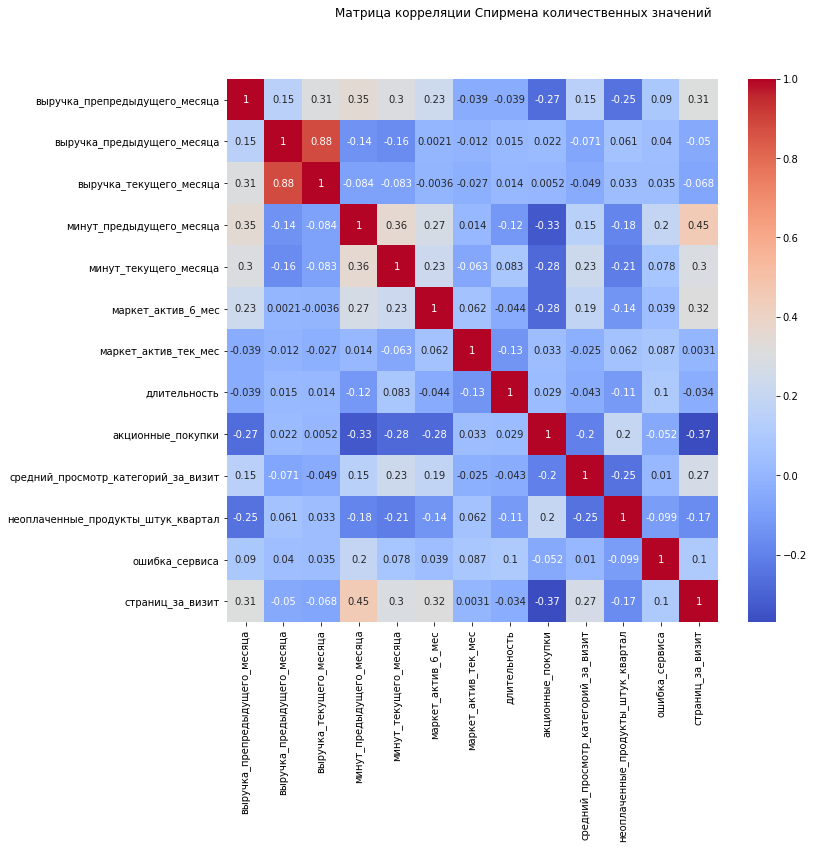

In [59]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена количественных значений')
sns.heatmap(df.corr(method="spearman"), annot=True, cmap='coolwarm');

Построим тепловую карту корреляции phi(k) для количественных данных распределение которых ненормальное с выбросами.

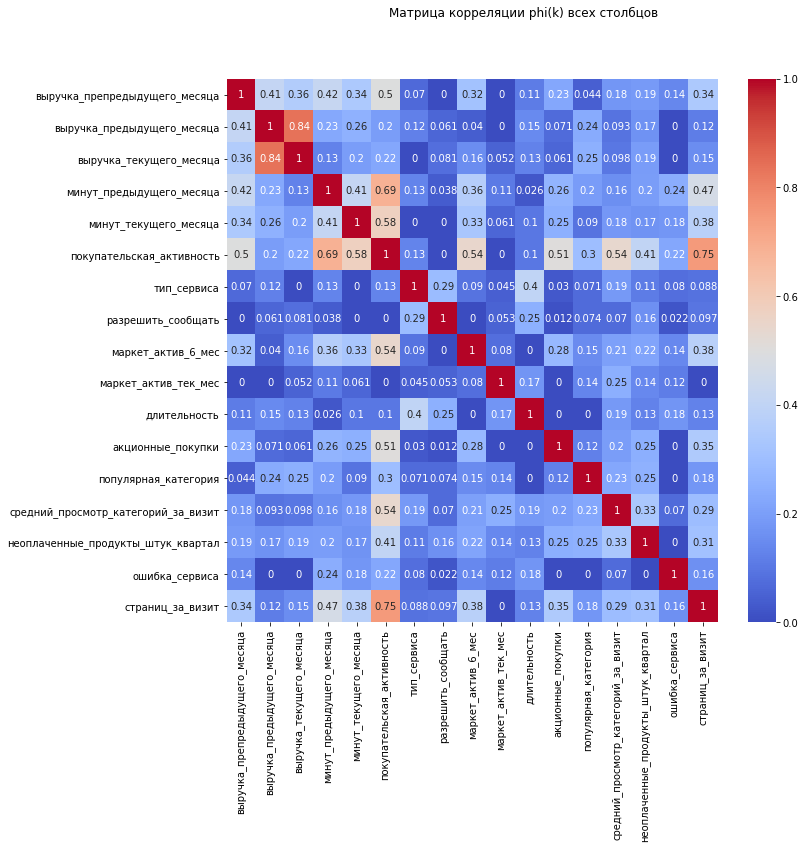

In [60]:
interval_cols = ['выручка_препредыдущего_месяца',
                 'выручка_предыдущего_месяца', 
                 'выручка_текущего_месяца',
                 'минут_предыдущего_месяца',
                 'минут_текущего_месяца',
                 'маркет_актив_6_мес',
                 'длительность',
                 'акционные_покупки'
                 ]
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Вывод по корреляционному анализу**

Между входными параметрами отсутствует связь выше 0,9 следовательно мультиколлинеарность отсутствует.
+ Максимальное значение корреляция Спирмена (непараметрическая мера оценивающая монотонность связи) corr(S) = 0,88
+ Максимальное значение корреляция phi(k) (учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных) phi(k) = 0,84

## Использование пайплайнов

**Подготовка данных**

In [61]:
X = df.drop(['покупательская_активность'], axis=1)
y = df['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify = y)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

le = LabelEncoder()
le.fit_transform(y_train.unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(972, 16)

(324, 16)

(972,)

(324,)

Значениям ['Прежний уровень' 'Снизилась'] назначено соответственно [0 1]


Кодирование целевого признака проведено корректно

Создадим списки с названиями признаков

In [62]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

In [63]:
df['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [64]:
num_columns = ['выручка_препредыдущего_месяца',       
               'выручка_предыдущего_месяца',          
               'выручка_текущего_месяца',             
               'минут_предыдущего_месяца',            
               'минут_текущего_месяца',               
               'маркет_актив_тек_мес',
               'маркет_актив_6_мес',
               'длительность',                        
               'акционные_покупки',                   
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',  
               'ошибка_сервиса',                      
               'страниц_за_визит']

Создадим пайплайн для подготовки признаков из списка `ohe_columns`: заполнение пропусков и `OHE-кодирование`

In [65]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Создадим пайплайн для подготовки признаков из списка `ord_columns`: заполнение пропусков и `Ordinal-кодирование`

In [66]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет'],
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим общий пайплайн для подготовки данных

In [67]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучим модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().

**Для оценки и сравнения эффективности обученных моделей машинного обучения необходимо выбрать универсальную метрику. Одной из таких метрик является ROC-AUC — показатель, который отражает способность модели к корректному прогнозированию.**


**ROC-AUC демонстрирует, насколько хорошо модель классифицирует данные. Для качественной модели значение ROC-AUC должно быть выше 0,9 и стремиться к 1. Однако важно учитывать, что оценку следует проводить на основе результатов, полученных на тестовой выборке.***

   + Кривая ROC отображает частоту истинных положительных и ложных срабатываний при различных порогах классификации, тогда как AUC показывает совокупную меру производительности модели машинного обучения по всем возможным порогам классификации.
   + ROC означает «Receiver Operating Characteristic» (кривая рабочих характеристик приемника). Это – график, который показывает эффективность модели машинного обучения при решении задачи классификации, отображая частоту истинных срабатываний и частоту ложных срабатываний. AUC расшифровывается как «Area Under the Curve» (площадь под кривой). Она используется для измерения всей площади под кривой ROC.

Создадим итоговый пайплайн: подготовка данных и модель

In [68]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 500),
        'models__max_features': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1')],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    }
]

model = RandomizedSearchCV(
                                pipe_final,
                                param_grid, 
                                cv=5,
                                scoring='roc_auc',
                                random_state=RANDOM_STATE,
                                n_jobs=-1
).fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', model.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', model.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [69]:
print('Площадь ROC-кривой на кросс-валидации:', model.best_score_)
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_test)
roc_auc_km = (roc_auc_test - model.best_score_) / model.best_score_*100
print(f'Потеря качества на тестовой выборке  = {-roc_auc_km:.2f} %')

Площадь ROC-кривой на кросс-валидации: 0.8405466085920631
Площадь ROC-кривой на тестовой выборке: 0.8432633580067144
Потеря качества на тестовой выборке  = -0.32 %


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Тестирование проведено верно.</font>

**Вывод по использованию пейплайнов и выбора лучшей модели**

Лучшая модель: SVC(degree=9, kernel='sigmoid', probability=True, random_state=42)

Параметры модели удвлетворительные:
+ Площадь ROC-кривой на тренировочной выборке: 0.840
+ Площадь ROC-кривой на тестовой выборке: 0.843

##  Анализ важности признаков

***Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP***

In [70]:
best_model = model.best_estimator_
best_preprocessor = model.best_estimator_.named_steps['preprocessor']

X_train_trans = pd.DataFrame(best_preprocessor.transform(X_train), columns=best_preprocessor.get_feature_names_out())
X_train_trans = X_train_trans.sample(frac=0.1, replace=True, random_state=42)
X_test_trans = pd.DataFrame(best_preprocessor.transform(X_test), columns=best_preprocessor.get_feature_names_out())
X_test_trans = X_test_trans.sample(frac=0.1, replace=True, random_state=42)

explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans, nsamples=100, random_state=RANDOM_STATE)

  0%|          | 0/32 [00:00<?, ?it/s]

In [71]:
best_model = model.best_estimator_
best_preprocessor = model.best_estimator_.named_steps['preprocessor']

X_train_trans = pd.DataFrame(best_preprocessor.transform(X_train), columns=best_preprocessor.get_feature_names_out())
X_test_trans = pd.DataFrame(best_preprocessor.transform(X_test), columns=best_preprocessor.get_feature_names_out())

explainer = shap.SamplingExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans, nsamples=100, random_state=RANDOM_STATE)

  0%|          | 0/324 [00:00<?, ?it/s]

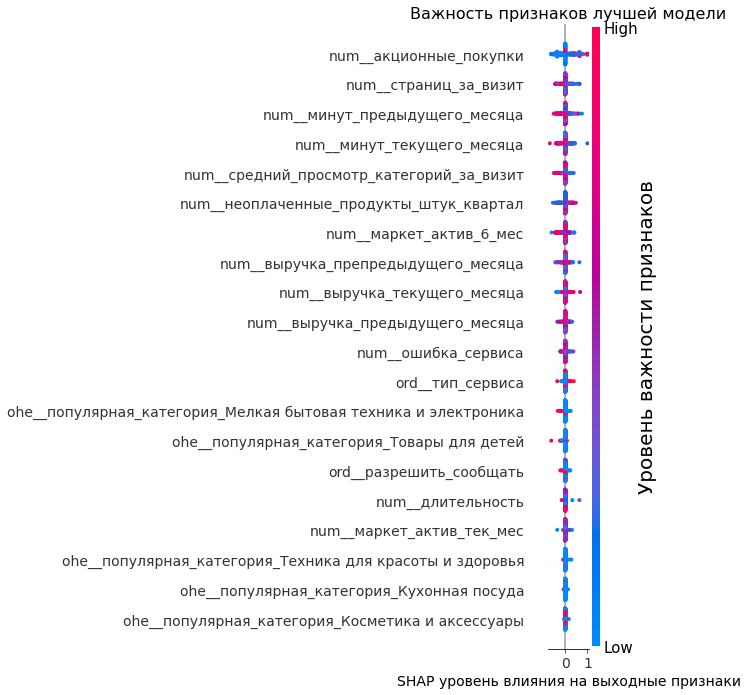

In [72]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, show=False)

# Получение текущих объектов
fig, ax = plt.gcf(), plt.gca()

# Изменение основных параметров графика
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)

# Получить цветовую панель
cb_ax = fig.axes[1] 

# Изменение параметров цветовой панели
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)

plt.show()

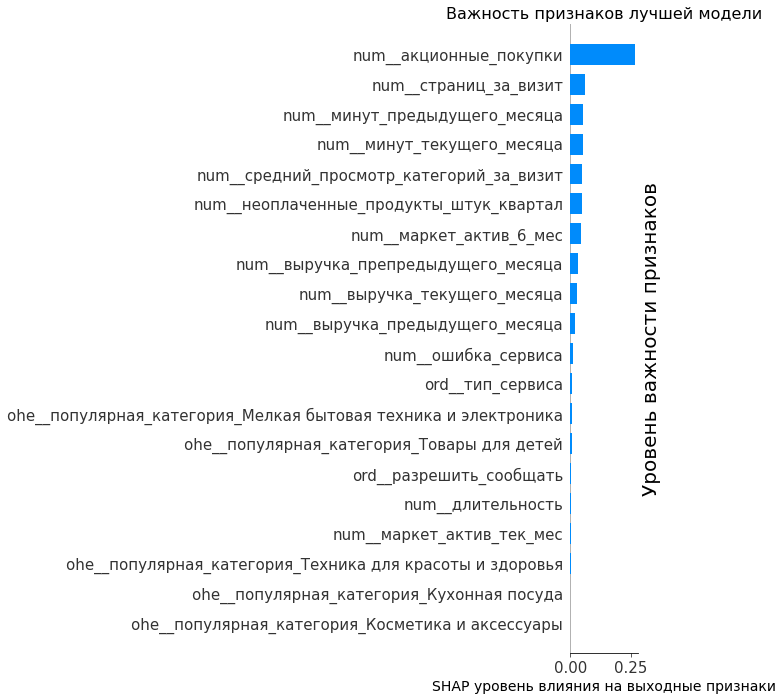

In [73]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, plot_type='bar', show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)
cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=15)
cb_ax.yaxis.set_label_position("right")
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)
plt.show();

**Выводы о значимости признаков:**

Отобрана лучшая модель: `SVC(degree=9, kernel='sigmoid', probability=True, random_state=42)`

Наиболее важные признаки (по убывающей):
+ 'акционные покупки'
+ 'средний_просмотр_категорий_за_визит'
+ 'минут_текущегого_месяца'
+ 'страниц_за_визит'
+ 'маркет_актив_6_мес' 

Менее важные признаки :
+ 'популярная категория_Техника для красоты и здоровья
+ 'популярная_категория_Товары для детей'
+ 'разрешить_сообщать'
+ 'популярная_категория_Косметика и аксесуары'
+ 'маркет_актив_тек_мес'

##  Сегментация покупателей

### Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей

Проведём прогнозирование с использованием модели, задав определённый порог и рассмотрев вероятности.

Исходя из процентного распределения данных в рамках нормального распределения по значениям стандартного отклонения, можно установить диапазон, в который попадают интересующие нас значения.
+ +- 1 СКО от медианного значения являются нормальными их объем примерно составит 68,26 %
+ ниже этого порогога низкий доход, а выше большой или примерно по 15,87 %

У нас нет связи с заказчиком, поэтому в данном проекте будем пользоваться таким распределением
- Создадим дополнительный столбец в `money`
- Сделаем объединение таблиц

In [74]:
med = money['прибыль'].median()
sko = np.std(money['прибыль'])
print("Медианное значение : ", med)
print("Стандартное отклонение : ", sko)
money['прибыль'].describe()

Медианное значение :  4.045
Стандартное отклонение :  1.0133321434255445


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Создадим функцию расчета предсказаний с учетом изменяемого порога

In [75]:
def custom_predict(X, threshold):
    probs = best_model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

Далее займемся предсказанием 

In [76]:
predictions_precision = custom_predict(X, threshold=0.5)

In [77]:
X['predictions'] = predictions_precision
X['probs'] = best_model.predict_proba(X)[:,1]

In [78]:
money['категории_прибыли'] = money['прибыль'].apply(lambda x: 'мало' if x < (med - sko) 
                                                       else ('много' if x > (med + sko) 
                                                       else 'нормально'))

Вернем индекс в таблицу для их объединения

In [79]:
X = X.reset_index()

In [80]:
X = pd.merge(X, money, on='id', sort=True)
X.head(10)

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,...,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,predictions,probs,прибыль,категории_прибыли
0,215349,4472.0,4971.6,5216.0,12,10,премиум,да,4.4,4,...,0.75,Товары для детей,4,4,2,5,1,0.743588,4.16,нормально
1,215350,4826.0,5058.4,5457.5,8,13,стандарт,нет,4.9,3,...,0.14,Домашний текстиль,5,2,1,5,0,0.102512,3.13,нормально
2,215351,4793.0,6610.4,6158.0,11,13,стандарт,да,3.2,5,...,0.99,Товары для детей,5,0,6,4,1,0.691594,4.87,нормально
3,215352,4594.0,5872.5,5807.5,8,11,стандарт,нет,5.1,3,...,0.94,Товары для детей,3,2,3,2,1,0.687421,4.21,нормально
4,215353,5124.0,5388.5,4738.5,10,10,стандарт,да,3.3,4,...,0.26,Домашний текстиль,4,1,1,4,1,0.671507,3.95,нормально
5,215354,4503.0,5869.6,5685.0,11,12,стандарт,да,5.1,3,...,0.23,Косметика и аксессуары,2,3,7,2,1,0.569841,3.62,нормально
6,215355,4749.0,3772.6,3263.0,12,10,стандарт,нет,4.7,4,...,0.17,Товары для детей,5,1,6,4,0,0.175506,5.26,много
7,215356,4433.0,4566.4,4146.5,6,7,стандарт,да,4.2,4,...,0.14,Косметика и аксессуары,2,2,1,3,1,0.568693,4.93,нормально
8,215358,4727.0,4209.5,3488.0,14,10,стандарт,да,4.7,4,...,0.13,Домашний текстиль,4,2,6,4,0,0.102760,3.06,нормально
9,215360,5555.0,5834.9,5304.5,9,6,премиум,да,3.9,3,...,0.35,Кухонная посуда,3,1,4,7,1,0.889306,4.55,нормально


Построим диаграмму рассеяния вероятности "Снижения покупательской активности" и прибыли для визуализации границы разделения на группы покупательской активности

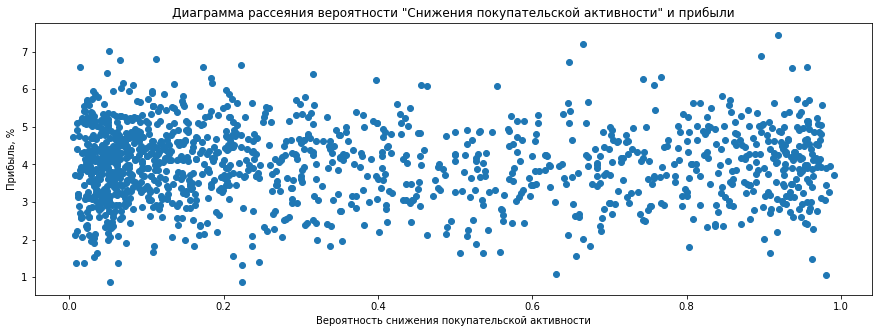

In [81]:
plt.figure(figsize=[15, 5])
plt.scatter(X.probs, X.прибыль);
plt.title('Диаграмма рассеяния вероятности "Снижения покупательской активности" и прибыли')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль, %')
plt.show()

Диаграмма не позволила в полной мере понять характер распределения данных, хотя можно предположить, что распределение имеет определённый разброс с понижением в районе среднего значения. Чтобы подтвердить это предположение, построим график распределения порога предсказания.

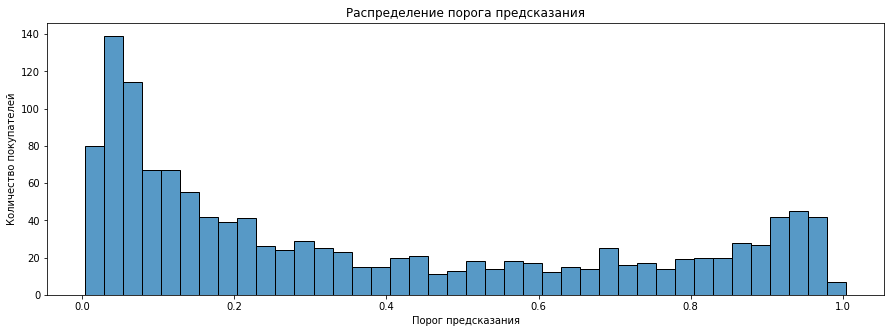

In [82]:
plt.figure(figsize=[15, 5])
sns.histplot(data=X, x='probs', binwidth=0.025)
plt.title('Распределение порога предсказания')
plt.xlabel('Порог предсказания')
plt.ylabel('Количество покупателей')
plt.show()
plt.show();

**Наша цель:**\
Для клиентов, чья покупательская активность снизилась, разработаем индивидуальные предложения, чтобы стимулировать их вернуться к покупкам.

Добавим в данные категориальный столбец для их сравнения. Границу разделения установим на уровне 0,79, поскольку диаграмма имеет форму «бабочки», и количество значений резко увеличивается после этого порога.

In [83]:
X['категория_снижения'] = X['probs'].apply(lambda x: 'Снизилась' if x > 0.79 else 'Прежний уровень')   

### Проведем исследование группы покупателей. Сделаем предложения по работе с сегментом для увеличения покупательской активности

Для анализа выделим группу клиентов с низким доходом и высокой вероятностью снижения покупательской активности. Для сравнения оставим группу, которая сохраняет прежний уровень покупок. Эта группа будет служить ориентиром, к которому следует стремиться, и поможет определить необходимые решения на основе ключевых признаков, выявленных на седьмом этапе работы.

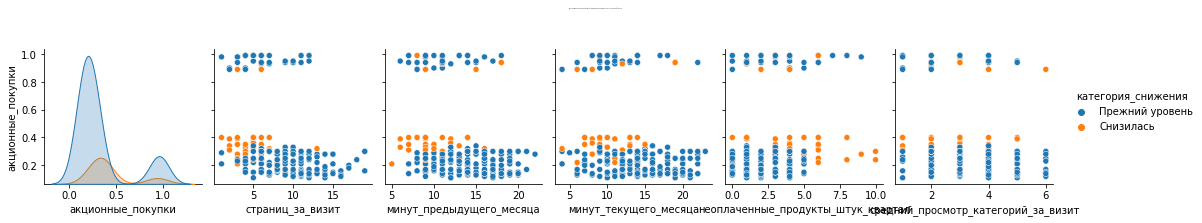

In [95]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]

y=['акционные_покупки'
  ]

g = sns.pairplot(X.query('категории_прибыли == "мало"'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=1)
plt.show()

**Выделим группу клиентов, количество покупок акционных товаров не превышают 3 штук.**\
Сформулируем предложение по работе с сегментом для увеличения покупательской активности.

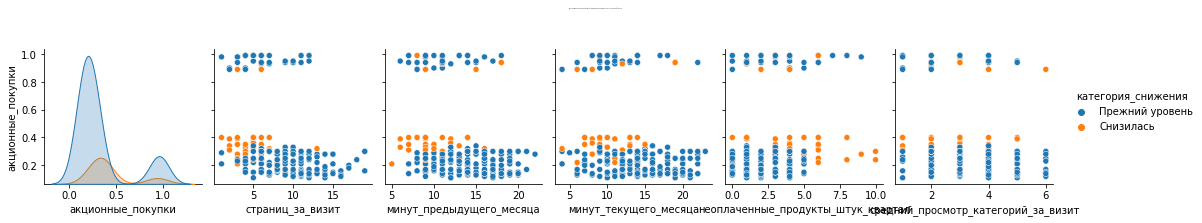

In [96]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]
y=['акционные_покупки'
  ]

g = sns.pairplot(X.query('категории_прибыли == "мало" & акционные_покупки < 3'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=1)
plt.show()

 ### Определенные сегменты и их анализ

 **Группа клиентов, количество акционных товаров у которых не превышает 3 штук**

В данном сегменте зафиксировано уменьшение уровня покупательской активности. Особенно заметно снижение среди клиентов, совершивших менее трёх акционных покупок. При этом те, кто приобрёл товары по акции три раза, могут считаться потенциально активными пользователями. Вероятно, это обусловлено сокращением количества рекламных акций.

**Рекомендации:**

- Отобрать этих клиентов в отдельную группу для работы и принять меры по повышению их активности:
  - Чаще предлагать им акционные товары, активизировать уведомления и запустить рекламные кампании;
  -  Способствовать увеличению количества просмотренных страниц, чтобы продлить время, проведённое на сайте за один визит. Если визит длится более десяти минут, вероятность сохранения покупательской активности возрастает;
  - Стимулировать их интерес к страницам сайта: наблюдения показывают, что при просмотре более шести страниц уровень покупательской активности сохраняется.

### Группа клиентов с высокой прибыльностью и более 4 неоплаченных покупок в корзине**

В этом сегменте также наблюдается значительное снижение покупательской активности.

**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу и для увеличения их активности:
  - Уведомлять их, если в корзине более 6 неоплаченных товаров. Это может вернуть их на сайт, повысить важные метрики и увеличить покупательскую активность.


**Выделим группу клиентов, с высокой  прибыльностью и количества неоплаченных покупок в корзине больше 4**\
Сформулируем предложение по работе с сегментом для увеличения покупательской активности.

Прибыль от клиентов распределена нормально. Определим, что наиболее высокая прибыль клиентов лежит за 3 квантилем нормального распределения.

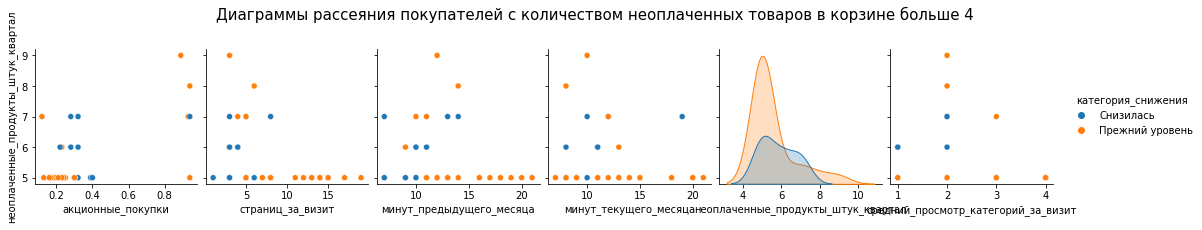

In [97]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]
y=['неоплаченные_продукты_штук_квартал'
  
  ]

g = sns.pairplot(X.query('категории_прибыли == "много" & неоплаченные_продукты_штук_квартал > 4'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с количеством неоплаченных товаров в корзине больше 4", y=1.2, fontsize=15)
plt.show()

**Промежуточный итог**

В сегменте присутствует значительная доля снижения покупательской активности клиентов.

Предлагается выделить таких клиентов в отдельную рабочую группу и для учеличения их активности:
+ Если в корзине окажется более шести неоплаченных товаров, покупателю будет направлено уведомление. Это может стимулировать его вернуться на сайт, улучшить ключевые показатели и повысить общую активность покупок.

В общем случае рекомендации такие же как и для предыдущей группы.

### Итоги

 ***Определенные сегменты и их анализ***

**Группа клиентов, количество акционных товаров у которых не превышает 3 штуки**

В данном сегменте зафиксировано уменьшение уровня покупательской активности, причём особенно заметно снижение среди клиентов, совершивших не более трёх покупок по акции. Вероятно, это обусловлено сокращением количества рекламных акций.

**Рекомендации:**

- Отобрать этих клиентов в отдельную группу для целенаправленной работы.
- Чаще предлагать им товары по акции и активизировать рекламные кампании.
- Стимулировать их интерес к страницам сайта: наблюдения показывают, что при просмотре более шести страниц уровень покупательской активности остаётся высоким.
- Побуждать к просмотру большего количества страниц, чтобы увеличить время, проведённое на сайте за один визит. Если посетитель проводит на сайте более десяти минут, вероятность сохранения покупательской активности возрастает.

**Группа клиентов с высокой прибыльностью и более 4 неоплаченных покупок в корзине**

В этом сегменте также наблюдается значительное снижение покупательской активности.

**Рекомендации:**

- Создать отдельную группу для работы с этими клиентами.
- Отправлять им уведомления, если в их корзине находится более шести неоплаченных товаров. Это может стимулировать их вернуться на сайт, улучшить ключевые показатели и повысить активность покупок.

Для обеих групп целесообразно применять следующие меры: активно продвигать товары по акциям, запускать рекламные кампании, стимулировать интерес к страницам сайта и информировать о товарах, оставленных в корзине без оплаты.

## Общий вывод

**1.Задача исследования**

Задача исследования заключалась в создании подхода для персонализации предложений постоянным клиентам с целью повышения их активности в покупках. Для проведения анализа были предоставлены следующие данные:

- `market_file.csv` — содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `market_money.csv` — с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv` — с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money.csv` — с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**2.Предобработка данных**

1. Изменены названия столбцов: перевод в нижний регистр и замена пробелов на подчеркивания.
2. В `market_file`:
   - В колонке `тип_сервиса` данные `стандартт` заменены на `стандарт`.
   - Изменены типы столбцов: `маркет_актив_6_мес` и `акционные_покупки` на float.
   
3. В `market_money`:
   - Изменен тип столбца `выручка` на float.
   
4. В `market_time`:
   - В колонке `период` данные `предыдцщий_месяц` заменены на `предыдущий_месяц`.

**3.Анализ данных и подготовка**

- Проведен исследовательский анализ данных.
- Проведена подготовка и объединение таблиц.
- Для поиска лучшей модели был проведен корреляционный анализ данных для исключения мультиколлинеарности.
- Подготовлены пайплайны для отбора лучшей модели в ручном и автоматическом режиме.

**4.Выбор лучшей модели**

Отобрана лучшая модель: `SVC(degree=9, kernel='sigmoid', probability=True, random_state=42)`

Наиболее важные признаки (по убывающей):
+ `акционные покупки`
+ `средний_просмотр_категорий_за_визит`
+ `минут_текущегого_месяца`
+ `страниц_за_визит`
+ `маркет_актив_6_мес` 

Менее важные признаки :
+ `популярная категория_Техника для красоты и здоровья`
+ `популярная_категория_Товары для детей`
+ `разрешить_сообщать`
+ `популярная_категория_Косметика и аксесуары`
+ `маркет_актив_тек_мес`

**Сегменты клиентов и рекомендации**

**1.Группа клиентов, у которых количество акционных товаров не превышает 3 штук**

В этом сегменте наблюдается снижение покупательской активности, особенно у клиентов с количеством акционных покупок, менее 3 штук. Возможно, это связано с уменьшением рекламных кампаний по акциям.

***Рекомендации:***

- Выделить таких клиентов в отдельную рабочую группу.
- Активно предлагать им акционные товары и проводить рекламные кампании.
- Задерживать их внимание на страницах сайта: при просмотре более 6 страниц активность остается на прежнем уровне.
- Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного на сайте: при более чем 10 минутах вероятность сохранения покупательской активности повышается.

**2.Группа клиентов с высокой прибыльностью и более 4 неоплаченных покупок в корзине**

В этом сегменте также наблюдается значительное снижение покупательской активности.
**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу и для увеличения их активности:
- Уведомлять их, если в корзине более 6 неоплаченных товаров. Это может вернуть их на сайт, повысить важные метрики и увеличить покупательскую активность.